# Demo - Targeted PGD with Imagenet

In [1]:
import numpy as np
import json
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

## 1. Load Data

In [6]:
normal_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
normal_loader = torch.utils.data.DataLoader(normal_data, batch_size=1, shuffle=False)

True Image & True Label


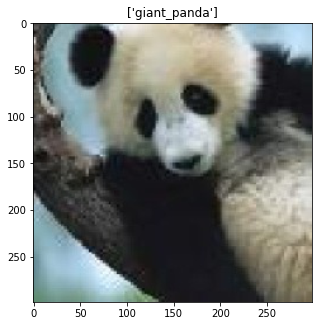

In [7]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 2. Attack Inception v3

In [8]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [9]:
# Adding normalization layer for Inception v3.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.inception_v3(pretrained=True)
).to(device)


In [10]:
model.eval()

# Perturb images to be classified as specific labels
TPGD = torchattacks.PGD(model, eps=0.3, alpha=2/255, steps=40, targeted=True)

Attack Image & Predicted Label


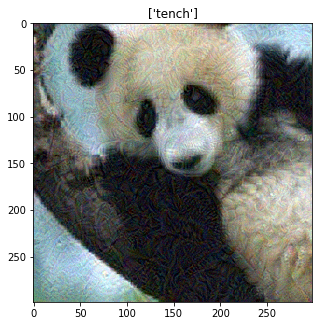

In [11]:
print("Attack Image & Predicted Label")

for images, labels in normal_loader:

    # normal_data.classes[0] = 'tench'
    attack_labels = torch.tensor([0])
    
    images = TPGD(images, attack_labels)
    labels = labels.to(device)
    outputs = model(images)

    _, pre = torch.max(outputs.data, 1)

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

Attack Image & Predicted Label


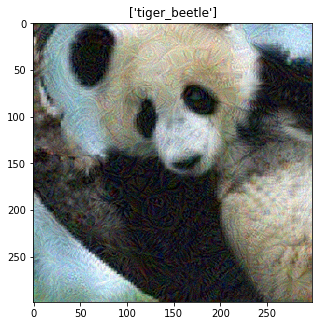

In [12]:
print("Attack Image & Predicted Label")

for images, labels in normal_loader:

    # normal_data.classes[300] = 'tiger_beetle'
    attack_labels = torch.tensor([300])
    
    images = TPGD(images, attack_labels)
    labels = labels.to(device)
    outputs = model(images)

    _, pre = torch.max(outputs.data, 1)

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])